## This code is to generate a whole tune with given (Xn, Xn+1).
The AI should predict (Xn+2) at first, then use (Xn+2) to predict (Xn+3), use (Xn+3) to predict (Xn+4) and so on...

In [1]:
from IPython.display import display, Image
import IPython.display as ipd
# import fluidsynth
from midi2audio import FluidSynth
import glob
import numpy as np
import pathlib
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import pretty_midi
import tensorflow as tf

from matplotlib import pyplot as plt

# Tomb added
import copy
import random
import sys

In [2]:
#Download Chorales
data_dir = pathlib.Path('/Volumes/MAGIC1/CS50/myMusicGen/data/chorales')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'midi',
      origin='https://github.com/jamesrobertlloyd/infinite-bach/tree/master/data/chorales/midi',
      extract=True,
      cache_dir='.', cache_subdir='data',
  )
filenames = glob.glob(str(data_dir/'**/*.mid*'))
print('Number of files:', len(filenames))

Number of files: 498


In [3]:
class UnsupportedMidiFileException(Exception):
  "Unsupported MIDI File"

In [4]:
"""Tomb made a pretty useful function"""
def check_pianoroll_dim(pianoroll):
        rows = len(pianoroll)  # This gives the number of rows
        columns = len(pianoroll[0])  # This assumes all rows have the same length

        print("Number of rows:", rows) # represents sequence length
        print("Number of columns:", columns) # represents the 4 octave range in midi 36-83
        print("Total dimesions of this pianoroll is", rows*columns)

In [5]:
"""Tomb made to check if there is a single one, all zeros, or multiple ones in the pitch vector"""

def check_ones_zeros(array):
    count_ones = np.count_nonzero(array == 1)
    count_zeros = np.count_nonzero(array == 0)

    if count_ones == 1 and count_zeros == array.size - 1:
        # print("There is only one '1' and the rest are '0's in the array.")
        return True
    elif count_zeros == array.size:
        # print("All elements in the array are '0's.")
        return True
    else:
        # print("There are either multiple '1's or different values in the array.")
        return False

In [6]:
"""Read_Midi 2"""

def read_midi(filename, sop_alto, seqlen):
  
  def get_pianoroll(midi, nn_from, nn_thru, seqlen, tempo):
    pianoroll = midi.get_piano_roll(fs=2*tempo/60) # shape(128, 1262) This is the core line which makes this matrix based on 8th note
    if pianoroll.shape[1] < seqlen:
        raise UnsupportedMidiFileException

    pianoroll = pianoroll[nn_from:nn_thru, 0:seqlen] # (48, 64) Pinoroll's value still NOT binary since it has velocity
    
    binary_pianoroll = np.heaviside(pianoroll, 0) # converting as a binary matrix
    transposed_pianoroll = np.transpose(binary_pianoroll) #(64, 48)
    # transposed_pianoroll = np.transpose(pianoroll)
    # return binary_pianoroll
    return transposed_pianoroll # type numpy.ndarray

  def add_rest_nodes(pianoroll: np.ndarray):  # If all the elemets are zero, the rest node says 1, else 0
        
        restList = []
        for i in pianoroll:
           result = check_ones_zeros(i) # Get boolen either TRUE or False
           if result: # Meaning one "1" and others are zeros or all zeros 
                rests = 1 - np.sum(i)
                # print("rests 1st condi", rests)
                restList.append(rests)
            
            #"There are either multiple '1's or different values in the array."
           else:
                total_sum = np.sum(i)
                rests = total_sum-total_sum # assign int 0 should be avoided as want the code to be dynamic
                # print("rests 2nd condi", rests)
                restList.append(rests)

        # print(type(restList))
        restList = np.array(restList)
        # print(restList.shape)
        restList = np.expand_dims(restList,1)
        # print(restList.shape)
        
        return np.concatenate([pianoroll, restList], axis=1)
  
  
  # read midi file
  midi = pretty_midi.PrettyMIDI(filename)

  # An Exception error is thrown if there is a modulation(key change)
  if len(midi.key_signature_changes) !=1:
    raise UnsupportedMidiFileException

  # Modulate the given key to C major or C minor
  key_number = midi.key_signature_changes[0].key_number

  # Get Major key(keynode=0) or Minor key(keynode=1)
  keymode = np.array([int(key_number / 12)])

  # The Exception error thrown when tempo changes
  tempo_time, tempo = midi.get_tempo_changes()
  if len(tempo) != 1:
    raise UnsupportedMidiFileException
  if sop_alto:
    # The exception thrown if there are less than 2 parts
    if len(midi.instruments) < 2:
      raise UnsupportedMidiFileException
    # Get pianoRoll returns numpy.ndarray
    pr_s = get_pianoroll(midi.instruments[0], 36, 84, seqlen, tempo[0])
    pr_a = get_pianoroll(midi.instruments[1], 36, 84, seqlen, tempo[0])
    pr_b = get_pianoroll(midi.instruments[2], 36, 84, seqlen, tempo[0])
    wholePart = get_pianoroll(midi, 36, 84, seqlen, tempo[0])
    
    sop_w_rest = add_rest_nodes(pr_s) 
    alt_w_rest = add_rest_nodes(pr_a)
    bass_w_rest = add_rest_nodes(pr_b)
    wholePart_w_rest = add_rest_nodes(wholePart)
    
    return sop_w_rest, alt_w_rest, bass_w_rest, wholePart_w_rest, keymode # All numpy.ndarray including keymode  

In [7]:
"""Make a Window to prepare the model data. 
Make the data(i.e manipulate the model as you tell it what you want) here 
for sequences (Xn, Xn+1) -> Xn+2 and then use Xn+2 to predict Xn+3, 
Xn+3 to predict Xn+4, and so forth"""

np.set_printoptions(threshold=np.inf) # Show the entire print, esp Matrix

x_all = [] # (30690, 2) Total dimesions is 61380
y_all = [] # 30690 Total dimesions is 30690
files = [] # Number of files 498 but for collected files, there are 3 files that SKIPPED so we'll only see 495 files. E.g (495, int, int)
# keymodes = [] 

raw_seq_length =64

# repeat the process with all the midi files
for file in glob.glob(str(data_dir/"**/*.mid*")):
  files.append(file)
  try:
    #make a window to get sequence 
    sop_data, alt_data, bass_data, whole_part_data, keymode = read_midi(file, sop_alto=True, seqlen=raw_seq_length) # For Read Midi 2
    desiredData = alt_data
    for i in range(len(desiredData)-2): # range(0, 62) to predict until the 63rd step
      # Get (x1,x2) and (x3)vectors  
      input_sequence = desiredData[i:i+2]
      # output_target = desiredData[i+2:i+3] # Predicting one step at a time
      output_target = desiredData[i+2] 
      
      x_all.append(input_sequence)
      y_all.append(output_target)
      

  # throw exception for midi data which can not be used
  except UnsupportedMidiFileException:
    print("nah")

n_notes = len(x_all) # 30690
print(check_pianoroll_dim(x_all)) 
print(check_pianoroll_dim(y_all))
print("Number of files",len(files))
print("n_notes!",n_notes)

nah
nah
nah
Number of rows: 30690
Number of columns: 2
Total dimesions of this pianoroll is 61380
None
Number of rows: 30690
Number of columns: 49
Total dimesions of this pianoroll is 1503810
None
Number of files 498
n_notes! 30690


In [8]:
input_data = np.array(x_all) # shape (30690, 2, 49) 30690 = 495*62
output_data = np.array(y_all) # shape (30690, 1, 49)  <class 'numpy.ndarray'>

i_train, i_test = train_test_split(range(len(input_data)),test_size=int(len(input_data)/2)) 
x_train = input_data[i_train] # <'numpy.ndarray'> shape (15345, 2, 49) [[[0. 0...  This operation extracts rows from input_data specified by the indices present in i_train.
x_test = input_data[i_test] # <'numpy.ndarray'> shape (15345, 2, 49) [[[0. 0... For example, if i_train contains [0, 2, 4], input_data[i_train] will extract rows 0, 2, and 4 from input_data.

y_train = output_data[i_train] # shape(15345, 1, 49) [[[0. 0. 0. 0. 0. ..
y_test = output_data[i_test] # shape(15345, 1, 49) [[[0. 0. 0. 0. 0

# <<<reshape>>>
# x_train_reshaped = x_train.reshape(-1,2, 49)  # Reshape to sequences of 2 elements
# x_test_reshaped = x_test.reshape(-1, 2, 49)
# # Reshape y_train and y_test to match the output shape
# y_train_reshaped = y_train.reshape(-1, 49)  # Reshape to target for each sequence
# y_test_reshaped = y_test.reshape(-1, 49)

# print("x_train",x_train.shape)
# print("y_train",y_train.shape)
# print("x_train_reshaped",x_train_reshaped.shape)
# print("y_train_reshaped",y_train_reshaped.shape)

In [9]:
seq_length = x_train.shape[1] #int 2 # How many sequences for input features
pitch_range = x_train.shape[2] # or simply int 49

In [10]:
# Create an LSTM model
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64, input_shape=(seq_length, pitch_range)))  # Input shape corresponds to the reshaped data
model.add(tf.keras.layers.Dense(pitch_range, activation='sigmoid'))  # Adjust the output units and activation based on your problem

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  # Adjust loss and metrics


In [11]:
# # Define the model
# model = tf.keras.Sequential()

# # Add an LSTM layer
# model.add(tf.keras.layers.LSTM(128, input_shape=(2, 49)))  # Adjust units (128) based on your task

# # Output layer
# model.add(tf.keras.layers.Dense(49, activation='sigmoid'))  # Adjust output size based on your task

# # Reshape the output to match the sequence length and features
# model.add(tf.keras.layers.Reshape((1, 49)))

# # Compile the model
# model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])


In [12]:
# Train the model

callbacks = [tf.keras.callbacks.ModelCheckpoint(
        filepath="./training_checkpoints/ckpt_{epoch}",
        save_weights_only=True
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="loss",
        patience=5,
        verbose=1,
        restore_best_weights=True
    )]

epochs = 50
batch_size = 32

model.evaluate(x_train, y_train, return_dict=True)

history = model.fit(
    x_train, y_train, 
    batch_size=batch_size, 
    epochs=epochs, 
    callbacks=callbacks,
    validation_data=(x_test, y_test))

model.evaluate(x_train, y_train, return_dict=True)

480/480 [==============================] - 1s 524us/step - loss: 0.6937 - accuracy: 0.0152
Epoch 1/50
480/480 [==============================] - 2s 2ms/step - loss: 0.1590 - accuracy: 0.1928 - val_loss: 0.0703 - val_accuracy: 0.3175
Epoch 2/50
480/480 [==============================] - 1s 2ms/step - loss: 0.0653 - accuracy: 0.3995 - val_loss: 0.0598 - val_accuracy: 0.4388
Epoch 3/50
480/480 [==============================] - 1s 2ms/step - loss: 0.0552 - accuracy: 0.4893 - val_loss: 0.0521 - val_accuracy: 0.5159
Epoch 4/50
480/480 [==============================] - 1s 2ms/step - loss: 0.0501 - accuracy: 0.5455 - val_loss: 0.0487 - val_accuracy: 0.5642
Epoch 5/50
480/480 [==============================] - 1s 2ms/step - loss: 0.0473 - accuracy: 0.5835 - val_loss: 0.0467 - val_accuracy: 0.5888
Epoch 6/50
480/480 [==============================] - 1s 2ms/step - loss: 0.0457 - accuracy: 0.5987 - val_loss: 0.0458 - val_accuracy: 0.5940
Epoch 7/50
480/480 [==============================] - 1s 

{'loss': 0.0414254255592823, 'accuracy': 0.6201368570327759}

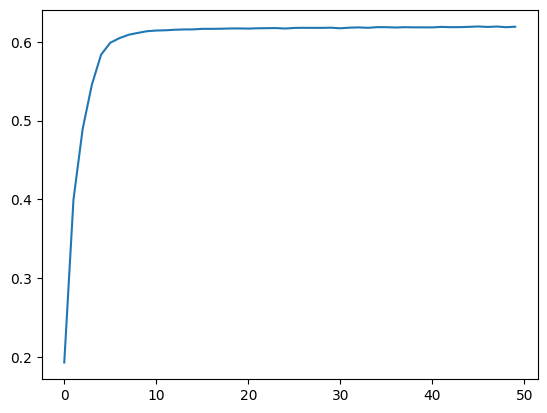

In [13]:
plt.plot(history.epoch, history.history['accuracy'], label='total loss')
plt.show()

In [14]:
"""Renamed as play_midi as the new viersion of the show_play func, 
<show> per se will be worked on later, maybe I want it to be a musical score"""

_SAMPLING_RATE = 16000
# make a fucntion to be able to do so
def play_midi(x_test:np.array, y_pred: np.array, filename): #x_test(2, 49), y_pred (62, 49)
  
  def make_midi(x_test:np.array, y_pred:np.array, filename):
      midi = pretty_midi.PrettyMIDI(resolution=480)
      instr = pretty_midi.Instrument(program=1)
      duration_balance=0.5
      for index, test_vector in enumerate(x_test): 
        for i in range(len(test_vector)): # the test_vector shape is similar to prPred   
            if test_vector[i] > 0.5:
                print("x test pitch:", i, "| value:", test_vector[i])
                instr.notes.append(pretty_midi.Note(start=0.5*index,
                                                        end=0.5*(index+1),
                                                        pitch=36+i,
                                                        velocity=100)) 
                
      # for yIndex, pred_vector in enumerate((y_pred)): #range(0, 62)
      #   #We are getting prob distribution between 0-1. Keep notes closer to 1, dump notes closer to 0
      #   #0.5 is only a threshold, coud be any number between 0-1 
      #   for p in range(len(pred_vector)): #(0, 49)
      #     if pred_vector[p] > 0.5: # check the TS note how it looks like
              
      #         print("y pred pitch:",p ,"| value:", pred_vector[p])
      #         # print("pianoroll>0.5",pianoroll[i])
      #         # print("y pred index!!",yIndex)
              
      #         instr.notes.append(pretty_midi.Note(start=(0.5*index)+(0.5*yIndex)+duration_balance,
      #                                             end=0.5*(index+1)+(0.5*yIndex)+duration_balance,
      #                                             pitch=36+p,
      #                                         velocity=100)) 
                                     
      midi.instruments.append(instr)
      
      midi.write(f"{filename}.mid")
      
      # instrument = midi.instruments[0]
      # for note in instrument.notes:
      #    print(f"Pitch:{note.pitch}, Start:{note.start}, End Time:{note.end}")


  ## Save the midi data into a file, the file name is given in the next cell as output.midi
  make_midi(x_test, y_pred, filename)

  # Convert MIDI to Wav so that you can listen to it on web browser
  fs = FluidSynth(sound_font="/Volumes/MAGIC1/FluidR3_GM/FluidR3_GM.sf2")
  fs.midi_to_audio(f"{filename}.mid", f"{filename}.wav")

  ipd.display(ipd.Audio(f"{filename}.wav", rate=_SAMPLING_RATE))

In [15]:
def make_yPred(x_test:np.array):
    # print("Before expansion", x_test.shape)
    input = np.expand_dims(x_test, axis=0)
    # print("After expansion", input.shape)
    prediction = model.predict(input, verbose="mute")
    
    return prediction 

In [39]:
k = random.randint(0, len(x_test))  # Get a random song INDEX.
original_x_test_k = copy.deepcopy(x_test[k])
print(original_x_test_k)
print("---")

all_y_predictions = []  # Store all predictions

for i in range(raw_seq_length - 2):
    # print("x_test b4 up", x_test[k])
    prediction = make_yPred(x_test[k])  # (1, 49) Make prediction for the current x_test[k]
    all_y_predictions.append(prediction)
    x_test[k][0], x_test[k][1] = x_test[k][1], prediction[0]  # Update the last vector of x_test with the prediction for the next iteration
    # print("x_test after up", x_test[k])

# Convert predictions to numpy array and squeeze the dimensions
all_y_predictions = np.array(all_y_predictions)
all_y_predictions = np.squeeze(all_y_predictions)  # Shape (62, 49) numpy.ndarray

# Call play_midi function with original sequence and all predictions
# play_midi(original_x_test_k, all_y_predictions, "data/output_KP3")


[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1.]]
---
[[8.36151628e-08 9.72943255e-08 9.51393559e-08 8.03007936e-08
  7.08994037e-08 1.86827765e-06 6.54576661e-06 1.11446845e-07
  7.17216011e-08 2.33506785e-06 1.17706377e-05 1.83979919e-05
  4.91269806e-04 9.65701403e-08 1.12326561e-05 5.02078865e-06
  2.97308929e-04 2.55383693e-05 5.98348415e-05 1.00812456e-03
  1.74698071e-05 3.34631652e-03 2.65647494e-03 6.78424258e-03
  8.04869831e-03 4.13484965e-03 2.49289908e-02 3.11061693e-03
  1.98452305e-02 1.45154092e-02 8.98736995e-03 1.47733260e-02
  5.32553531e-03 1.31220734e-02 3.93931940e-03 1.31600932e-03
  1.40869594e-03 2.11843551e-04 5.61713183e-04 4.98250483e-06
  1.51036029e-05 6.08192477e-06 1.74673232e-06 3.99239798e-04
  8.9

### --Unused or test code below---

In [17]:
"""The custome window test.
Must understand that each vector represents 1 single note as one-hot encoded.
The word in data per se has nothing to do with this program but only to see how the window slides clearly"""

testListX = []
testListY = []


data = [["apple", "banana", "peach"], ["choco", "pineapple", "melon"], 
        ["avocado", "pizza", "sushi"], ["car", "taxi", "bus"], ["cat", 'dog', 'pig']]
for i in range(len(data)-2): 
    input_test = data[i:i+2]
    output_test = data[i+2:i+3]
    # print("--input--")
    # print(input_test)
    # print("--output--")
    # print(output_test)
    testListX.append(input_test)
    testListY.append(output_test)

input_dataTest = np.array(testListX) 
output_dataTest = np.array(testListY)

print("input_dataTest", input_dataTest)
print()
print("output_dataTest", output_dataTest)
print()
print("input_dataTest Shape", input_dataTest.shape)
print("output_dataTest Shape", output_dataTest.shape)

input_dataTest [[['apple' 'banana' 'peach']
  ['choco' 'pineapple' 'melon']]

 [['choco' 'pineapple' 'melon']
  ['avocado' 'pizza' 'sushi']]

 [['avocado' 'pizza' 'sushi']
  ['car' 'taxi' 'bus']]]

output_dataTest [[['avocado' 'pizza' 'sushi']]

 [['car' 'taxi' 'bus']]

 [['cat' 'dog' 'pig']]]

input_dataTest Shape (3, 2, 3)
output_dataTest Shape (3, 1, 3)


In [18]:
# y_pred = model.predict(x_test) # y pred shape (15345, 1, 49) <class 'numpy.ndarray'>